In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.mixture import GaussianMixture
import scipy.stats as st
from sklearn.model_selection import train_test_split

label_to_name = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')#.sample(frac=1)


# Separate features (X) and labels (y) for training and testing
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

# normalize/scale the pixel values to [0, 1]
X_train = X_train / 255.0


print(len(X_train))


60000


In [3]:
# Fit Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# MDDA - using GMMs per class
n_components = 5  # Chosen based on complexity
gmm_models = {}
for label in np.unique(y_train):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_train[y_train == label])
    gmm_models[label] = gmm

# Predict using MDDA
def predict_mdda(X):
    probs = np.zeros((X.shape[0], len(gmm_models)))
    for label, gmm in gmm_models.items():
        probs[:, label] = gmm.score_samples(X)  # Log-likelihood of the data under each GMM
    return np.argmax(probs, axis=1)

In [94]:
SAMPLES = 10000
test_data = pd.read_csv('./data/fashion-mnist_test.csv')#.sample(frac=1)
test_data = test_data.sample(SAMPLES, random_state=2)

X_test = test_data.iloc[:, 1:].values  
y_test = test_data.iloc[:, 0].values
X_test = X_test / 255.0

In [97]:
# Get predictions and probabilities from Random Forest
rf_probs = rf_classifier.predict_proba(X_test)
rf_predictions = rf_classifier.predict(X_test)

# Store the most confident correct predictions for each class
rf_most_confident = {}

for label in np.unique(y_test):
    # Get indices of correctly predicted instances for the current class
    correct_indices = np.where((rf_predictions == label) & (y_test == label))[0]
    
    # If there are any correct predictions for this class
    if len(correct_indices) > 0:
        # Find the instance with the highest predicted probability (certainty) for the correct class
        best_index = correct_indices[np.argmax(rf_probs[correct_indices, label])]
        best_certainty = rf_probs[best_index, label]  # Certainty is the probability of the predicted class
        
        # Store the image and the certainty
        rf_most_confident[label] = (X_test[best_index], best_certainty)

# Now `rf_most_confident` holds the most confident correct prediction for each class


In [96]:
from scipy.special import softmax


def z_score_normalization(log_probs):
    mean_log_probs = np.mean(log_probs, axis=1, keepdims=True)
    std_log_probs = np.std(log_probs, axis=1, keepdims=True) + 1e-8  # Add small constant to avoid division by zero
    normalized_log_probs = (log_probs - mean_log_probs) / std_log_probs
    return normalized_log_probs

def predict_mdda_with_normalized_log_likelihoods(X):
    log_probs = np.zeros((X.shape[0], len(gmm_models)))
    for label, gmm in gmm_models.items():
        log_probs[:, label] = gmm.score_samples(X)
    
    # Normalize the log-likelihoods
    normalized_log_probs = z_score_normalization(log_probs)
    
    # Convert to probabilities via softmax
    probs = softmax(normalized_log_probs, axis=1)
    
    # Get the predicted class and its probability
    predictions = np.argmax(probs, axis=1)
    certainties = np.max(probs, axis=1)  # Probability of the predicted class
    
    return predictions, certainties


mdda_predictions, mdda_probs = predict_mdda_with_normalized_log_likelihoods(X_test)
# print(mdda_probs)

# Store the most confident correct predictions for each class in MDDA
mdda_most_confident = {}

for label in np.unique(y_test):
    # Get indices of correctly predicted instances for the current class
    correct_indices = np.where((mdda_predictions == label) & (y_test == label))[0]
    
    # If there are any correct predictions for this class
    if len(correct_indices) > 0:
        # Find the instance with the highest certainty for the correct class
        best_index = correct_indices[np.argmax(mdda_probs[correct_indices])]
        best_certainty = mdda_probs[best_index]  # Certainty is already calculated for the predicted class
        
        # Store the image and the certainty
        mdda_most_confident[label] = (X_test[best_index], best_certainty)


# Now `mdda_most_confident` holds the most confident correct prediction for each class

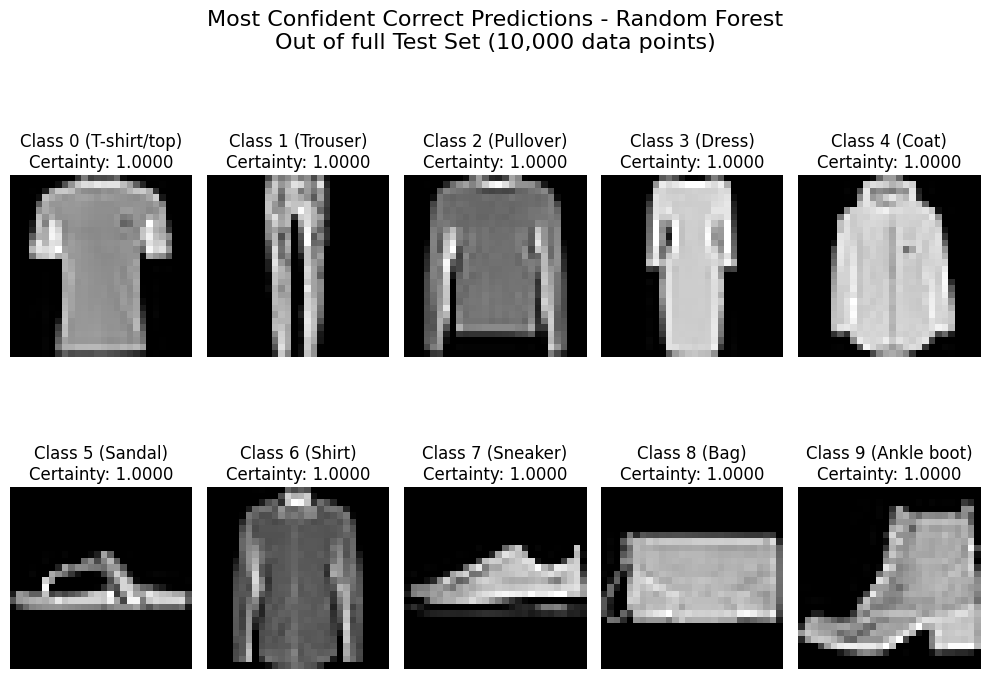

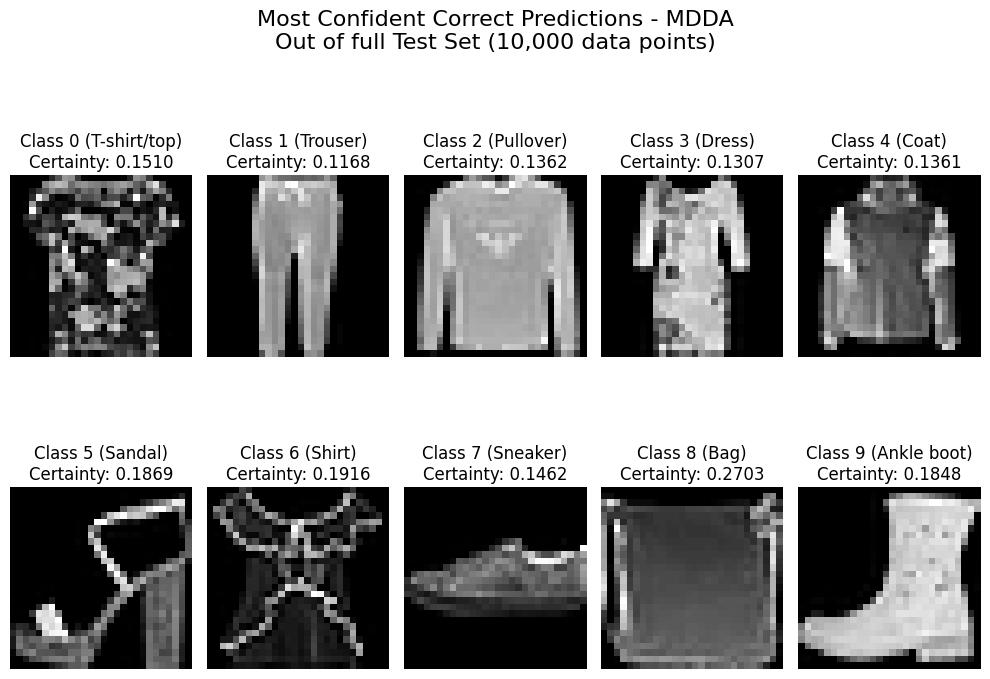

In [98]:
import matplotlib.pyplot as plt

# Function to plot the most confident predictions
def plot_most_confident(classifier_name, most_confident_dict):
    plt.figure(figsize=(10, 8))
    for idx, label in enumerate(most_confident_dict.keys()):
        plt.subplot(2, 5, idx+1)
        image, certainty = most_confident_dict[label]
        plt.imshow(image.reshape(28, 28), cmap='gray')  # Assuming the images are 28x28 pixels
        plt.title(f"Class {label} ({label_to_name[label]})\nCertainty: {certainty:.4f}")
        plt.axis('off')
    plt.suptitle(f"Most Confident Correct Predictions - {classifier_name}\nOut of full Test Set (10,000 data points)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the most confident predictions for Random Forest
plot_most_confident('Random Forest', rf_most_confident)

# Plot the most confident predictions for MDDA
plot_most_confident('MDDA', mdda_most_confident)
